<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Training%20Pipeline%20and%20molecular%20fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [1]:
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 16.8 MB/s 
     |████████████████████████████████| 59 kB 4.1 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 30 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=0f465d59db73656f0e1af91dc28ba8186d7bd280432a104d73ecadce7c92cfd3
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 719 kB 32.5 MB/s 
     |██████████████████████████

In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from collections import Counter
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data 1

In [4]:


def from_csv_to_data(path, dep_var):

  df_drug_comb = pd.read_csv(path, index_col = 0)
  df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
  df_drug_comb.drop(['QA','Challenge'], axis = 1, inplace = True)
  procs = [Categorify, FillMissing]
  # We shuffle the data
  df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
  dataset_size = df_drug_comb.shape[0]
  complete_list = np.arange(dataset_size, dtype = int)
  mask_train = df_drug_comb["Dataset"]=="train"
  train_idx = complete_list[mask_train]

  test_idx = complete_list[~mask_train]



  splits = (list(train_idx),list(test_idx))

  df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
  df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)
  cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
  to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)
  xs,y = to.train.xs,to.train.y
  valid_xs,valid_y = to.valid.xs,to.valid.y
  return xs,y, valid_xs,valid_y

In [ ]:
path = "/content/gdrive/MyDrive/archivos_tfm/drug_comb_commutative.csv"
dep_var = 'Synergy score'
xs,y, valid_xs,valid_y = from_csv_to_data(path, dep_var)

## Minimum model

In [26]:
def from_csv_to_data_minimum(path, dep_var):
  "This is for the dataset where we have already removed QA and challenge"
  df_drug_comb = pd.read_csv(path, index_col = 0, header = 0)
  
  procs = [Categorify, FillMissing]
  # We shuffle the data
  df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
  dataset_size = df_drug_comb.shape[0]
  complete_list = np.arange(dataset_size, dtype = int)
  mask_train = df_drug_comb["Dataset"]=="train"
  train_idx = complete_list[mask_train]

  test_idx = complete_list[~mask_train]



  splits = (list(train_idx),list(test_idx))

  df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
  test_df = df_drug_comb.iloc[test_idx]
  df_nocomb = df_drug_comb.drop(['Combination ID', "Challenge"], axis = 1)
  cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
  to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)
  xs,y = to.train.xs,to.train.y
  valid_xs,valid_y = to.valid.xs,to.valid.y
  return xs,y, valid_xs,valid_y, test_df, df_nocomb, splits

In [ ]:
"We put the minimum information: cell lines and compound names"
path = "/content/gdrive/MyDrive/archivos_tfm/dminimum_without_smiles.csv"
dep_var = 'Synergy score'
xs_min,y_min, valid_xs_min,valid_y_min, test_df_min, df_nocomb_min, splits_min = from_csv_to_data_minimum(path, dep_var)

In [ ]:
"We create permutated xs_valid_min_perm"
valid_xs_min_perm = pd.DataFrame()
valid_xs_min_perm[['Cell line name', 
                   'Compound A', 'Compound B']] = valid_xs_min[['Cell line name', 'Compound B', 'Compound A']]

## Minimum model + Molecular Fingerprints

We are going to add molecular fingerprints to see how the prediction improves

In [ ]:
path = "/content/gdrive/MyDrive/archivos_tfm/dminimum_w_smiles.csv"
dep_var = 'Synergy score'
xs_min_sm,y_min_sm, valid_xs_min_sm,valid_y_min_sm, test_df_min_sm, df_nocomb_min_sm, splits_min_sm = from_csv_to_data_minimum(path, dep_var)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
xs_min_sm.drop(['Drug_A_SMILES','Drug_B_SMILES'], axis = 1, inplace = True)
valid_xs_min_sm.drop(['Drug_A_SMILES','Drug_B_SMILES'], axis = 1, inplace = True)


SettingWithCopyError: ignored

In [ ]:
valid_xs_min_sm.head(10)

Cell line name  Compound A  Compound B  Drug_A_FPT1_na  ...  \
0                5          40           1               1  ...   
2               15          41          16               1  ...   
8               81          43           9               1  ...   
10              43          13           3               1  ...   
19              74          40          38               1  ...   
22               7          49          27               1  ...   
30              66          68          12               1  ...   
31              42          32           2               1  ...   
32              16          65           6               1  ...   
34              19          43           9               1  ...   

    Drug_B_FPT163  Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
0             1.0            1.0            1.0            0.0  
2             1.0            1.0            1.0            0.0  
8             1.0            1.0            1.0            0.0  
10            1.0            1.0            1.0            0.0  
19            1.0            1.0            1.0            0.0  
22            1.0            1.0            1.0            0.0  
30            1.0            1.0            1.0            0.0  
31            1.0            1.0            1.0            0.0  
32            1.0            1.0            1.0            0.0  
34            1.0            1.0            1.0            0.0  

[10 rows x 667 columns]

In [ ]:
"We check the columns, it is a pain in the ass to do the permutation"
columns = valid_xs_min_sm.columns
print(list(columns)[3:169])
print(list(columns)[169:168*2-1])
print(list(columns)[168*2-1:167*3])
print(list(columns)[167*3:167*4])

['Drug_A_FPT1_na', 'Drug_A_FPT2_na', 'Drug_A_FPT3_na', 'Drug_A_FPT4_na', 'Drug_A_FPT5_na', 'Drug_A_FPT6_na', 'Drug_A_FPT7_na', 'Drug_A_FPT8_na', 'Drug_A_FPT9_na', 'Drug_A_FPT10_na', 'Drug_A_FPT11_na', 'Drug_A_FPT12_na', 'Drug_A_FPT13_na', 'Drug_A_FPT14_na', 'Drug_A_FPT15_na', 'Drug_A_FPT16_na', 'Drug_A_FPT17_na', 'Drug_A_FPT18_na', 'Drug_A_FPT19_na', 'Drug_A_FPT20_na', 'Drug_A_FPT21_na', 'Drug_A_FPT22_na', 'Drug_A_FPT23_na', 'Drug_A_FPT24_na', 'Drug_A_FPT25_na', 'Drug_A_FPT26_na', 'Drug_A_FPT27_na', 'Drug_A_FPT28_na', 'Drug_A_FPT29_na', 'Drug_A_FPT30_na', 'Drug_A_FPT31_na', 'Drug_A_FPT32_na', 'Drug_A_FPT33_na', 'Drug_A_FPT34_na', 'Drug_A_FPT35_na', 'Drug_A_FPT36_na', 'Drug_A_FPT37_na', 'Drug_A_FPT38_na', 'Drug_A_FPT39_na', 'Drug_A_FPT40_na', 'Drug_A_FPT41_na', 'Drug_A_FPT42_na', 'Drug_A_FPT43_na', 'Drug_A_FPT44_na', 'Drug_A_FPT45_na', 'Drug_A_FPT46_na', 'Drug_A_FPT47_na', 'Drug_A_FPT48_na', 'Drug_A_FPT49_na', 'Drug_A_FPT50_na', 'Drug_A_FPT51_na', 'Drug_A_FPT52_na', 'Drug_A_FPT53_na', '

In [ ]:
columns_perm = ['Cell line name','Compound B', 'Compound A']+ list(columns)[169:168*2-1]+list(columns)[3:169]+ list(columns)[167*3:167*4]+ list(columns)[168*2-1:167*3]
print(len(columns_perm))

667


In [ ]:
valid_xs_min_sm_perm = pd.DataFrame()
valid_xs_min_sm_perm[columns] = valid_xs_min_sm[columns_perm]
valid_xs_min_sm_perm.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Cell line name  Compound A  Compound B  Drug_A_FPT1_na  ...  \
0                5           1          40               2  ...   
2               15          16          41               2  ...   
8               81           9          43               1  ...   
10              43           3          13               1  ...   
19              74          38          40               1  ...   
22               7          27          49               1  ...   
30              66          12          68               2  ...   
31              42           2          32               2  ...   
32              16           6          65               2  ...   
34              19           9          43               1  ...   

    Drug_B_FPT163  Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
0             1.0            1.0            1.0            0.0  
2             1.0            1.0            1.0            0.0  
8             1.0            1.0            1.0            0.0  
10            1.0            1.0            1.0            0.0  
19            1.0            1.0            1.0            0.0  
22            1.0            1.0            1.0            0.0  
30            1.0            1.0            1.0            0.0  
31            1.0            1.0            1.0            0.0  
32            1.0            1.0            1.0            0.0  
34            1.0            1.0            1.0            0.0  

[10 rows x 667 columns]

# Loading Data 2
We use the reduced dataset where the only drug combinations included are the ones with 2 smiles codes. In that we we don't have so many nan comlumns.

In [13]:
path = "/content/gdrive/MyDrive/archivos_tfm/smiles/dataset_selected_comb_smiles.csv"
df_drug_comb = pd.read_csv(path, index_col = 0)
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
df_drug_comb.drop(['QA','Challenge'], axis = 1, inplace = True)
print(list(df_drug_comb.columns))


['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A', 'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B', 'Synergy score', 'Combination ID', 'Dataset', 'Drug_A_SMILES', 'Drug_A_FPT1', 'Drug_A_FPT2', 'Drug_A_FPT3', 'Drug_A_FPT4', 'Drug_A_FPT5', 'Drug_A_FPT6', 'Drug_A_FPT7', 'Drug_A_FPT8', 'Drug_A_FPT9', 'Drug_A_FPT10', 'Drug_A_FPT11', 'Drug_A_FPT12', 'Drug_A_FPT13', 'Drug_A_FPT14', 'Drug_A_FPT15', 'Drug_A_FPT16', 'Drug_A_FPT17', 'Drug_A_FPT18', 'Drug_A_FPT19', 'Drug_A_FPT20', 'Drug_A_FPT21', 'Drug_A_FPT22', 'Drug_A_FPT23', 'Drug_A_FPT24', 'Drug_A_FPT25', 'Drug_A_FPT26', 'Drug_A_FPT27', 'Drug_A_FPT28', 'Drug_A_FPT29', 'Drug_A_FPT30', 'Drug_A_FPT31', 'Drug_A_FPT32', 'Drug_A_FPT33', 'Drug_A_FPT34', 'Drug_A_FPT35', 'Drug_A_FPT36', 'Drug_A_FPT37', 'Drug_A_FPT38', 'Drug_A_FPT39', 'Drug_A_FPT40', 'Drug_A_FPT41', 'Drug_A_FPT42', 'Drug_A_FPT43', 'Drug_A_FPT44', 'Drug_A_FPT45', 'Drug_A_FPT46', 'Drug_A_FPT47', 'Drug_A_FPT48', 'Drug_A_FPT49', 'Drug_A_FPT50', 'Drug_A_FPT51

In [33]:
dep_var = 'Synergy score'
xs,y, valid_xs,valid_y, test_df, df_nocomb, splits = from_csv_to_data_minimum(path, dep_var)

In [34]:
xs.drop(['Drug_A_SMILES','Drug_B_SMILES'], axis = 1, inplace = True)
valid_xs.drop(['Drug_A_SMILES','Drug_B_SMILES'], axis = 1, inplace = True)

SettingWithCopyError: ignored

In [44]:
columns = list(test_df.columns)

We create a minimum model and a minimum + smiles model. 
Minimum model:

In [75]:
xs_min = xs[['Cell line name', 'Compound A', 'Compound B']].copy()
valid_xs_min = valid_xs[['Cell line name', 'Compound A', 'Compound B']].copy()
valid_xs_min_perm = pd.DataFrame()

valid_xs_min_perm[['Cell line name', 
                   'Compound A', 
                   'Compound B']] = valid_xs[['Cell line name', 
                                              'Compound B', 'Compound A']].copy()

Minimum + smiles

In [76]:
"First we create the columns"
column_1 = ['Cell line name', 'Compound A', 'Compound B']
columns_2 = columns[16:182]
columns_3 = columns[183:]
columns_selected = column_1 + columns_2 + columns_3
columns_perm = ['Cell line name', 'Compound B', 'Compound A'] + columns_3 + columns_2

xs_min_sm = xs[columns_selected].copy()
valid_xs_min_sm = valid_xs[columns_selected].copy()
valid_xs_min_sm_perm = pd.DataFrame()
valid_xs_min_sm_perm[columns_selected] = valid_xs[columns_perm].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [78]:
valid_xs_min_sm

Cell line name  Compound A  Compound B  Drug_A_FPT1  ...  Drug_B_FPT163  \
1                  2          22          15            1  ...              1   
2                 11          29          25            1  ...              1   
9                  7          25           3            1  ...              1   
14                45          26          13            1  ...              1   
18                17           9           3            1  ...              1   
...              ...         ...         ...          ...  ...            ...   
2712              21          27           5            1  ...              1   
2713              40          17           8            1  ...              1   
2716              33          29           9            1  ...              1   
2718              48          19          11            1  ...              1   
2725              27          22          14            1  ...              1   

      Drug_B_FPT164  Drug_B_FPT165  Drug_B_FPT166  
1                 1              1              1  
2                 1              1              1  
9                 1              1              1  
14                1              1              1  
18                1              1              1  
...             ...            ...            ...  
2712              1              1              1  
2713              1              1              1  
2716              1              1              1  
2718              1              1              1  
2725              1              1              1  

[764 rows x 335 columns]

# Evaluating functions

In [20]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

In [21]:
def nan_weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        rho_list.append(rho_i)
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

In [22]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear

# Baseline model: mean and median

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [ ]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747145652770996


We create our metrics

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.099112 
 Error Mean = 27.98169


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.

In [ ]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

We make a function that accounts for possible values of nan's in the dataset and sets them to 0.


In [ ]:
def nan_weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        rho_list.append(rho_i)
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

And one that only gives metric for fast training:

In [ ]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear

In [ ]:
test_df = df_drug_comb.iloc[test_idx]
test_df

Cell line name  Compound A     Compound B  Max. conc. A  ...        H B  \
5           HT-1197        FGFR            AKT           3.0  ...   2.531000   
11           BT-549    PIK3CA_4            AKT           1.0  ...   1.182479   
12          UM-UC-3      HDAC_4            AKT           3.0  ...  10.000000   
14             SW48     MAP2K_1         IGFR_4           3.0  ...   0.499136   
17          HCC1143       ATR_4            AKT           1.0  ...   1.159155   
...             ...         ...            ...           ...  ...        ...   
5256        MFM-223         AKT         ADAM17           1.0  ...   0.000000   
5260        HCC1806      MTOR_1           FASN           1.0  ...  10.000000   
5261            RKO         TKI        MAP2K_1           3.0  ...   0.969392   
5262        CAL-120  TNKS_PARP6  PIK3CB_PIK3CD           1.0  ...  10.000000   
5265      NCI-H1975      TOP2_2            IAP           3.0  ...   0.493178   

          Einf B  Synergy score            Combination ID  
5      58.538453      -3.891046                  AKT.FGFR  
11     34.658416      12.835160              AKT.PIK3CA_4  
12     85.598780       3.115130                AKT.HDAC_4  
14      0.000000      35.711340            IGFR_4.MAP2K_1  
17     69.527524     -35.352060                 AKT.ATR_4  
...          ...            ...                       ...  
5256  100.000000      38.850700                ADAM17.AKT  
5260   75.080116     -50.139620               FASN.MTOR_1  
5261    0.000000      11.056320               MAP2K_1.TKI  
5262   70.299621      14.689200  PIK3CB_PIK3CD.TNKS_PARP6  
5265   71.768277      46.534060                IAP.TOP2_2  

[1680 rows x 13 columns]

**Sanity check:** we try the metric by predicting values around the mean of the synergy score of the train split. As this values are random, statistically they will be uncorrelated with the experimental values. We should obtain a weighted Pearson score close to 0.

In [ ]:
n_exp = len(test_idx)
y_pred = np.ones(n_exp)* mean  + np.random.random(n_exp)*1000
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)

Weighted Pearson:  0.020216299872922252


It's very small and oscillates around 0. 




# Decision Trees


In [ ]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

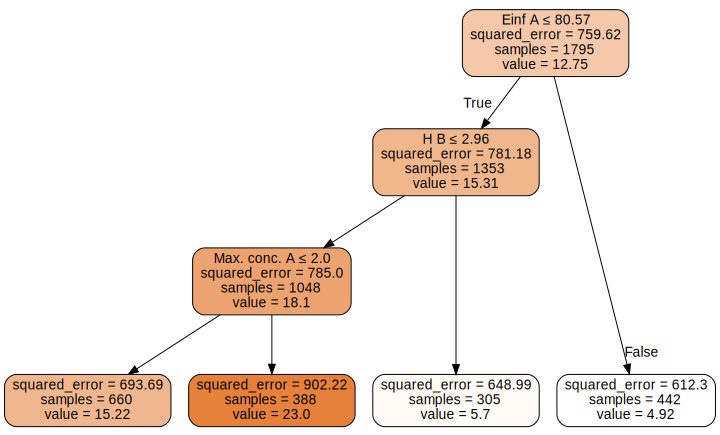

In [ ]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


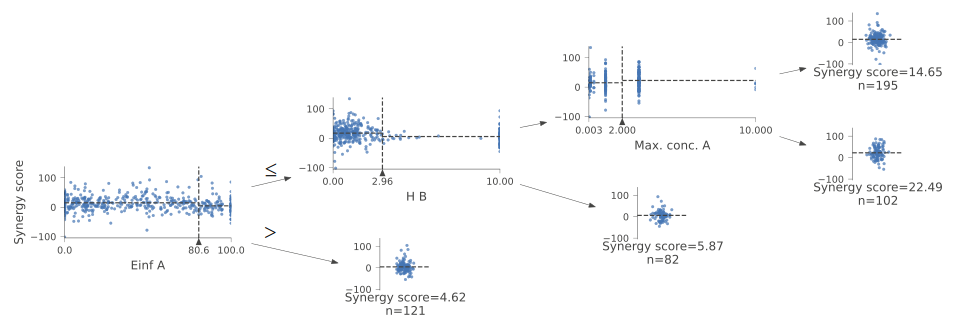

In [ ]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [ ]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [ ]:
m_rmse(m, valid_xs, valid_y)


36.81299

Now we will check for overfitting:

In [ ]:
m.get_n_leaves(), len(xs)

(1795, 1795)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.997595, 28.145969)

In [ ]:
m.get_n_leaves()


55

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [ ]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [ ]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 152 
 Error = 27.38495


Let's check our metric

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf = best_leaf)
m.fit(to.train.xs, to.train.y)
y_pred = m.predict(valid_xs)
print(test_df.shape)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)


(1089, 13)
Weighted Pearson:  nan
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


For some drug combination we obtain NaN's. My hypothesis is that for some drug pairs the predicted value is the same for all cell lines.

In [ ]:
check_nan = pear_weights_df["Pearson coefficient"].isnull()
combination_index = np.arange(pear_weights_df.shape[0], dtype = int)
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

Combination ID  n_cl  Pearson coefficient
54       ALK.CSNK2A1_2     6                  NaN
96   MTOR_1.TNKS_PARP6     7                  NaN
133    Cisplatin.PIK3C     3                  NaN
138      AKT.Cisplatin     3                  NaN
148    AKT.Chloroquine     5                  NaN
157     MTOR_1.SLC16A4     7                  NaN

These are the drug combinations that have a NaN Pearson correlation. We pick the first one and check for the predicted values.

In [ ]:
nan_mask = test_df["Combination ID"] == "ALK.CSNK2A1_2"
ALK_CSNK2A1_2_df = test_df[nan_mask]
ALK_CSNK2A1_2_df

Cell line name Compound A Compound B  Max. conc. A  ...       H B  \
217       NCI-H1563  CSNK2A1_2        ALK          0.03  ...  1.831949   
272        NCI-H522  CSNK2A1_2        ALK          0.03  ...  1.652920   
1386      NCI-H2085  CSNK2A1_2        ALK          0.03  ...  1.161107   
1633          SW900  CSNK2A1_2        ALK          0.01  ...  0.685584   
3290      NCI-H2291  CSNK2A1_2        ALK          0.01  ...  0.796128   
3331       NCI-H838  CSNK2A1_2        ALK          0.10  ...  1.619777   

        Einf B  Synergy score  Combination ID  
217   1.578234       5.147264   ALK.CSNK2A1_2  
272   0.000000     -15.121200   ALK.CSNK2A1_2  
1386  0.000000       9.019851   ALK.CSNK2A1_2  
1633  0.000000      15.030920   ALK.CSNK2A1_2  
3290  0.000000      16.914830   ALK.CSNK2A1_2  
3331  0.000000      16.545240   ALK.CSNK2A1_2  

[6 rows x 13 columns]

In [ ]:
y_pred_ALK_CSNK2A1_2 = y_pred[nan_mask]
y_pred_ALK_CSNK2A1_2

array([21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048])

Just as I imagined. We are predicting the same values over and over. That's why our metric fails.

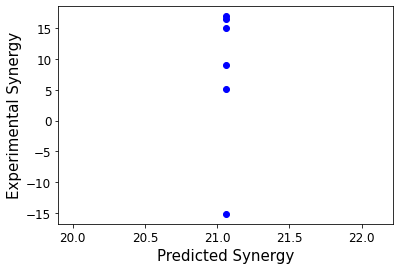

In [ ]:
plt.plot(y_pred_ALK_CSNK2A1_2 , ALK_CSNK2A1_2_df["Synergy score"] , "bo")
plt.ylabel("Experimental Synergy", fontsize = 15)
plt.xlabel("Predicted Synergy", fontsize = 15)
plt.savefig("predicted_experimental_synergy_decision_tree_nan.eps", format = 'eps', dpi=300)


Now with our metric function that takes nan's into account:


In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.11147801629765684
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Just to make sure we check for the previous rows of pear_weights_df where there were nan's.

In [ ]:
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

Combination ID  n_cl  Pearson coefficient
54       ALK.CSNK2A1_2     6                  0.0
96   MTOR_1.TNKS_PARP6     7                  0.0
133    Cisplatin.PIK3C     3                  0.0
138      AKT.Cisplatin     3                  0.0
148    AKT.Chloroquine     5                  0.0
157     MTOR_1.SLC16A4     7                  0.0

The function works.

# Random Forest

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(24.374761, 26.497797)

A little better than the Tree regressor, but not that great.

In [ ]:
y_pred = m.predict(valid_xs)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.16706360356491573
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.429530
1        FASN.MTOR_1     7            -0.013100
2         IAP.IGFR_3     3             0.884104
3        FGFR.MTOR_3     5             0.914940
4         IAP.PIK3CB    10             0.398945
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.755894
163      HSP90.PIK3C     3             0.304881
164  ATM.Gemcitabine     3            -0.278453
165     ATR_4.HDAC_4     3             0.999990
166   BCL2.CSNK2A1_2     6            -0.554555

[167 rows x 3 columns]


We see that Random Forest gives better prediction than Decision Trees. 

Let's try to obtain meaningful info. For example, let's order drug combinations from highest to lowest correlation

In [ ]:
ordered_df = pear_weights_df.sort_values(by = "Pearson coefficient",
                                         ascending = False)
print(ordered_df)

        Combination ID  n_cl  Pearson coefficient
165       ATR_4.HDAC_4     3             0.999990
31            FGFR.WNT     3             0.999920
8    Gemcitabine.PARP1     3             0.999857
156  EG5.PIK3CB_PIK3CD     3             0.998560
151        MAP2K_1.TKI     3             0.998325
..                 ...   ...                  ...
145  AKT_1.Chloroquine     5            -0.803913
148    AKT.Chloroquine     5            -0.807129
77            IAP.SN38     3            -0.971769
65      IGFR_4.MAP2K_1     3            -0.992857
85      IGFR_3.MAP2K_1     3            -0.996501

[167 rows x 3 columns]


Now the most uncorrelated:

In [ ]:
ordered_df["abs Pearson"] = np.abs(ordered_df["Pearson coefficient"])
ordered_df = ordered_df.sort_values(by ="abs Pearson",
                                         ascending = True)
ordered_df.head(10)

Combination ID  n_cl  Pearson coefficient  abs Pearson
123          BCL2.MAP2K_1     3             0.005340     0.005340
122          FGFR.SLC16A4     6            -0.008699     0.008699
20        FGFR.TNKS_PARP6     7            -0.009324     0.009324
107  CarboTaxol.CSNK2A1_2     5            -0.009835     0.009835
1             FASN.MTOR_1     7            -0.013100     0.013100
137            AKT.HDAC_4     5            -0.015835     0.015835
117    ADAM17.BCL2_BCL2L1     7             0.022154     0.022154
13   ADAM17.PIK3CB_PIK3CD     8            -0.025216     0.025216
118             AKT.ATR_4    10            -0.027071     0.027071
149       Cisplatin.PARP1     3             0.028164     0.028164

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

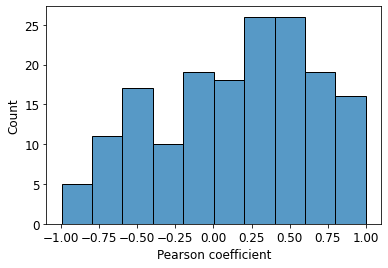

In [ ]:
sns.histplot(data = ordered_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_random_forest.eps", format = 'eps', dpi=300)


Let's try to do a bit of hyperparameter tuning to check for the best hyperparameters for random forest. 

In [ ]:
def rf_training(xs, y, test_df, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, random_state = 42, **kwargs):
   m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf,random_state = random_state , 
        oob_score=True)
   m.fit(xs, y)      
   y_pred = m.predict(valid_xs)
   weighted_pear = wpc_score(test_df, y_pred)
   return weighted_pear

Let's try our function and see if it reproduces previous results.

In [ ]:
rf_training(xs, y, test_df)

0.186327856782357

Close enough, the small difference can be explained by the fact that we didn't fix the random seed. Let's try some hyperparameter tuning.

# Tabular learner fastai
As next model we will try a Tabular Learner from FastAI. 
First thing we have to do is normalize the data. We create another TabularPandas object:


In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)

Now we create our dataloader and check for the maximum and minimum of our data. This is useful as we will limit the output interval of our model

In [ ]:
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

(-178.6540985107422, 237.37640380859375)

We create our learner and look for an optimal learning rate with lr_find.

SuggestedLRs(valley=0.0010000000474974513)

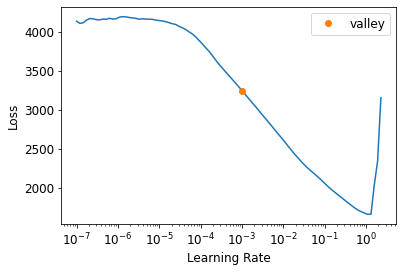

In [ ]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[200,50, 20],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()


Now we finetune our learner by a few epochs.



In [ ]:
learn.fit_one_cycle(50, 1e-3)


Lastly, we obtain our predictions and compute the WPC metric. Since the FastAI learner outputs a tensor, we have to Flatten it.


In [ ]:
y_pred, targs = learn.get_preds()
y_pred = np.asarray(y_pred[:,0])
wpc_score(test_df, y_pred)


0.10968063703535985

In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.10968063703535985
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.727809
1        FASN.MTOR_1     7             0.467770
2         IAP.IGFR_3     3            -0.944783
3        FGFR.MTOR_3     5             0.505273
4         IAP.PIK3CB    10             0.643841
..               ...   ...                  ...
162   Cisplatin.FGFR     3             0.678983
163      HSP90.PIK3C     3            -0.456856
164  ATM.Gemcitabine     3             0.647182
165     ATR_4.HDAC_4     3             0.328268
166   BCL2.CSNK2A1_2     6             0.292057

[167 rows x 3 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

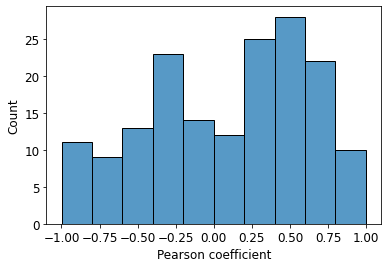

In [ ]:
sns.histplot(data = pear_weights_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_tabular_learner.eps", format = 'eps', dpi=300)

# Ensemble: Tabular Learner + Random Forest.

We will average predictions between Tabular Learner and Random Forest to create a superior model.

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, 
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [ ]:
"Random Forest"
m_rf_min = rf(xs_min, y_min);
"We take the two permutations and average"
y_pred_rf_1_min = m_rf_min.predict(valid_xs_min)
y_pred_rf_2_min = m_rf_min.predict(valid_xs_min_perm)
y_pred_rf_min = (y_pred_rf_1_min + y_pred_rf_2_min)/2
wpc_rf = wpc_score(test_df_min, y_pred_rf_min)


Let's see if performance increases when we use pearson correlation coefficient as metric and EarlyStopping and SaveModelCallback callbacks

In [ ]:
"Tabular learner"
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df_nocomb_min, 1, dep_var=dep_var)

"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"

to_nn = TabularPandas(df_nocomb_min, procs, cat, cont, y_names=dep_var, 
                      splits=splits_min)
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

callbacks = [EarlyStoppingCallback(
    monitor='pearsonr',
    min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]


learn = tabular_learner(dls, y_range=(y_min.min(),y_min.max()), layers=[30,20, 10],
                        n_out=1, loss_func=F.mse_loss, 
                        metrics = PearsonCorrCoef(), cbs = callbacks)
#learn.lr_find()


Better model found at epoch 0 with pearsonr value: -0.06776563367279943.
Better model found at epoch 1 with pearsonr value: -0.03175962547671991.
Better model found at epoch 2 with pearsonr value: -0.02286277082621248.
Better model found at epoch 3 with pearsonr value: -0.011954986027126017.
Better model found at epoch 4 with pearsonr value: -0.002277110785100211.
Better model found at epoch 5 with pearsonr value: 0.002081566584063742.
Better model found at epoch 25 with pearsonr value: 0.009107008970722582.
No improvement since epoch 5: early stopping


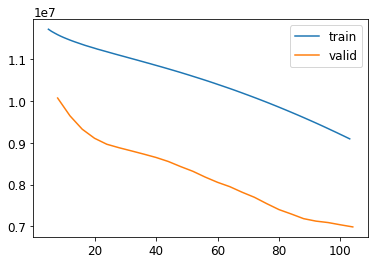

In [ ]:
learn.fit(n_epoch = 300, lr = 0.001)
learn.recorder.plot_loss()

In [ ]:
y_pred_nn_1, targs = learn.get_preds()
y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


wpc_tl = wpc_score(test_df_min, y_pred_nn_1)

let's save this learner and try to optimise it 
more.
We have now included the LB set in the test set so we save in again with a different name

In [ ]:
learn.save("/content/gdrive/MyDrive/archivos_tfm/tabular_model_commutative_lb.pth")

Path('/content/gdrive/MyDrive/archivos_tfm/tabular_model_commutative_lb.pth.pth')

In [ ]:
"And load it"
learn.load("/content/gdrive/MyDrive/archivos_tfm/tabular_model_commutative_lb.pth")
y_pred_nn_1, targs = learn.get_preds()
y_pred_nn_1 = np.asarray(y_pred_nn_1[:,0])


wpc_score(test_df, y_pred_nn_1)

0.22061368126847658

In [ ]:
valid_xs_perm_nn = to_nn.valid.xs.copy()

valid_xs_perm_nn[[ 'Compound A', 'Compound B', 
                         'Max. conc. A',
                         'Max. conc. B', 
                         'IC50 A', 'H A', 
                         'Einf A', 'IC50 B', 
                         'H B', 'Einf B']] = to_nn.valid.xs[[ 'Compound B', 'Compound A', 
                         'Max. conc. B',
                         'Max. conc. A', 
                         'IC50 B', 'H B', 
                         'Einf B', 'IC50 A', 
                         'H A', 'Einf A']]
valid_xs_perm_nn

NameError: ignored

In [ ]:
y_pred_nn_2, targs = learn.predict(valid_xs_perm_nn)
y_pred_nn_2 = np.asarray(y_pred_nn_2[:,0])


wpc_score(test_df, y_pred_nn_2)

AttributeError: ignored

I have not been able to use valid_xs_perm_nn to predict something in the tabular learner.

All together:

In [ ]:
y_pred_avg = (y_pred_rf_min + y_pred_nn_1 )/ 2
wpc_score(test_df_min, y_pred_rf_min)

0.04210829732193617

# XGBOOST

Out of curiosity, let's try XGBoost and ensemble it.

In [ ]:
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs_min, y_min)
y_pred_xgb_1 = m_xgb.predict(valid_xs_min)
y_pred_xgb_2 = m_xgb.predict(valid_xs_min_perm)
y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)
wpc_xgb = wpc_score(test_df_min, y_pred_xgb)


[09:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Now we ensemble RF, XGBoost and Tabular Learner.

In [ ]:
y_pred_avg = (y_pred_rf_min + y_pred_nn_1 + y_pred_xgb)/ 3
wpc_score(test_df_min, y_pred_avg)

0.015715949291313685

And only Random Forest and XGBoost

In [ ]:
y_pred_avg = (y_pred_rf_min +  y_pred_xgb)/ 2
wpc_score(test_df_min, y_pred_avg)

0.07769654601443739

# Support Vector Regressor

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb_min, procs_nn, cat, cont, y_names=dep_var, 
                      splits=splits_min)


In [ ]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(to_nn.train.xs, to_nn.train.y)
y_pred_SVR = m_SVR.predict(to_nn.valid.xs)

wpc_score(test_df_min, y_pred_SVR)

0.034569902157049075

With both permutations

In [ ]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(xs_min, y_min)
y_pred_SVR_1 = m_SVR.predict(valid_xs_min)
y_pred_SVR_2 = m_SVR.predict(valid_xs_min_perm)
y_pred_SVR = (y_pred_SVR_1 + y_pred_SVR_2)/2

wpc_svr = wpc_score(test_df_min, y_pred_SVR)

Now we ensemble the 4 of them:
Random Forest + XGBoost + Neural Networks + SVM

In [ ]:
y_pred_avg = (y_pred_rf_min + y_pred_nn_1 + y_pred_xgb + y_pred_SVR)/ 4
wpc_score(test_df_min, y_pred_avg)

0.016096785641785398

In [ ]:
"Only the best models"
y_pred_avg = (y_pred_rf_min  + y_pred_xgb + y_pred_SVR)/ 3
wpc_score(test_df_min, y_pred_avg)

0.09359673810006441

## Evaluation table

In [ ]:
"We create a table"
wpc_table = pd.DataFrame()
wpc_table["Models"] = ["Random Forest", "Tabular Learner", "XGBoost", "SVR"]
wpc_table["WPC"] = [wpc_rf, wpc_tl, wpc_xgb, wpc_svr]
print(wpc_table)

            Models       WPC
0    Random Forest  0.062230
1  Tabular Learner -0.009188
2          XGBoost  0.067531
3              SVR  0.051047


# Pipeline: training and evaluating all models
We are going to automate the process of obtaining this tables, thus making the training automatic.


In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, 
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)


def training_pipeline(xs,y, valid_xs,valid_y, valid_xs_perm, 
                      test_df, df_nocomb, splits, dep_var,tl_layers):
  "Random Forest"
  m_rf = rf(xs, y);
  "We take the two permutations and average"
  y_pred_rf_1 = m_rf.predict(valid_xs)
  y_pred_rf_2 = m_rf.predict(valid_xs_perm)
  y_pred_rf = (y_pred_rf_1 + y_pred_rf_2)/2
  wpc_rf = wpc_score(test_df_min, y_pred_rf)

  "Tabular learner"
  procs = [Categorify, FillMissing]
  cont,cat = cont_cat_split(df_nocomb_min, 1, dep_var=dep_var)

  "For some reason the prediction improves when I don't normalize"
  "so I will use procs instead of procs_nn"

  to_nn = TabularPandas(df_nocomb_min, procs, cat, cont, y_names=dep_var, 
                        splits=splits)
  dls = to_nn.dataloaders(1024)
  y = to_nn.train.y
  y.min(),y.max()

  callbacks = [EarlyStoppingCallback(
      monitor='pearsonr',
      min_delta=0.01, patience=20), SaveModelCallback(monitor='pearsonr')]


  learn = tabular_learner(dls, y_range=(y_min.min(),y_min.max()), layers=tl_layers,
                          n_out=1, loss_func=F.mse_loss, 
                          metrics = PearsonCorrCoef(), cbs = callbacks)

  learn.fit(n_epoch = 300, lr = 0.001)
  learn.recorder.plot_loss()

  wpc_tl = wpc_score(test_df, y_pred_nn_1)
  
  "XGBoost"
  m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                      subsample=0.7, colsample_bytree=0.8, random_state = 42)
  m_xgb.fit(xs, y)
  y_pred_xgb_1 = m_xgb.predict(valid_xs)
  y_pred_xgb_2 = m_xgb.predict(valid_xs_perm)
  y_pred_xgb = (y_pred_xgb_1 + y_pred_xgb_2)
  wpc_xgb = wpc_score(test_df, y_pred_xgb)
  
  
  "SVR"
  m_SVR = SVR(kernel="linear")
  m_SVR.fit(xs, y)
  y_pred_SVR_1 = m_SVR.predict(valid_xs)
  y_pred_SVR_2 = m_SVR.predict(valid_xs_perm)
  y_pred_SVR = (y_pred_SVR_1 + y_pred_SVR_2)/2
  wpc_svr = wpc_score(test_df_min, y_pred_SVR)
  
  "We create the table"
  wpc_table = pd.DataFrame()
  wpc_table["Models"] = ["Random Forest", "Tabular Learner", "XGBoost", "SVR"]
  wpc_table["WPC"] = [wpc_rf, wpc_tl, wpc_xgb, wpc_svr]
  
  return wpc_table

Minimum model

Better model found at epoch 0 with pearsonr value: -0.004289724500490042.
Better model found at epoch 1 with pearsonr value: -0.0019894358950744034.
No improvement since epoch 0: early stopping
[09:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
            Models       WPC
0    Random Forest  0.062230
1  Tabular Learner -0.009188
2          XGBoost  0.067531
3              SVR  0.051047


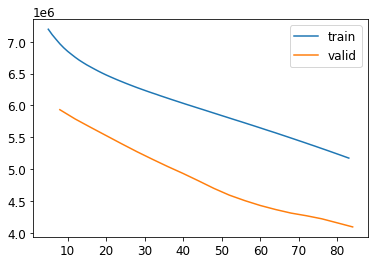

In [ ]:
dep_var = "Synergy score"
tl_layers = [30,20, 10]
minimum_wpc_table = training_pipeline(xs_min,y_min, 
                                      valid_xs_min,valid_y_min, valid_xs_min_perm, 
                      test_df_min, df_nocomb_min, splits_min, dep_var,tl_layers)
print(minimum_wpc_table)

Now minimum model + fingerprints

Better model found at epoch 0 with pearsonr value: -0.0055064916968683994.
Better model found at epoch 13 with pearsonr value: -0.0054666985657164735.
Better model found at epoch 14 with pearsonr value: -0.00247442571613115.
Better model found at epoch 15 with pearsonr value: -0.0006491277964667144.
Better model found at epoch 16 with pearsonr value: -0.0003027717438139044.
No improvement since epoch 0: early stopping
[11:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
            Models       WPC
0    Random Forest  0.030568
1  Tabular Learner -0.023227
2          XGBoost  0.027203
3              SVR -0.021975


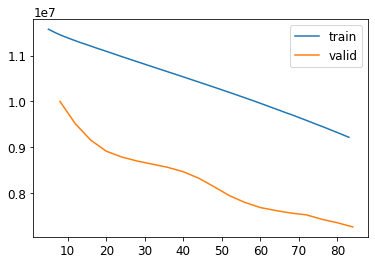

In [ ]:
dep_var = "Synergy score"
tl_layers = [40,20, 10]
m_sm_wpc_table = training_pipeline(xs_min_sm,
                                      y_min_sm, valid_xs_min_sm,valid_y_min_sm,
                                   valid_xs_min_sm_perm, 
                                   test_df_min_sm, df_nocomb_min_sm, splits_min_sm, 
                                   dep_var, tl_layers)
print(m_sm_wpc_table)


Something is wrong, later we'll see what to do. Maybe we should restrict the dataset to combinations where we have the smiles.

# What makes drugs predictable?
These has the sufficient accuracy to start studying what makes a drug be predictable. For that we are going to add our y_pred to our DataFrame of valid_xs

First we export y_pred of our current best model. Which uses an ensemble and commutativity.


In [ ]:

np.savetxt("/content/gdrive/MyDrive/archivos_tfm/y_pred_current_best_lb.txt", y_pred_avg)


Now we see how good are the predictions for every drug pair.

In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred_avg)


In [ ]:
pear_weights_df_ordered = pear_weights_df.sort_values("Pearson coefficient", 
                                                      axis = 0, ascending = False)
pear_weights_df_ordered

Combination ID  n_cl  Pearson coefficient
75     PIK3C.TNFSF10     5             0.989832
131       IAP.IGFR_4     5             0.958138
91      ATR_4.HDAC_4     5             0.918519
6      ERBB.PIK3CA_4    10             0.901655
11          FGFR.WNT     5             0.888264
..               ...   ...                  ...
161  Cisplatin.PARP1     5            -0.518792
127     MAP2K_1.PTK2     5            -0.522854
157  Cisplatin.PIK3C     5            -0.652726
66     HSP90.MAP2K_1     7            -0.705411
3     IGFR_4.MAP2K_1     5            -0.757527

[167 rows x 3 columns]

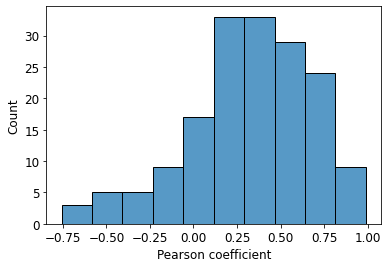

In [ ]:
sns.histplot(data = pear_weights_df_ordered["Pearson coefficient"], bins = 10)


We export the DatFrame to later analyze it.

In [ ]:
pear_weights_df_ordered.to_csv("/content/gdrive/MyDrive/archivos_tfm/Drug_comb_Pearson_test_set_lb.csv")